# Advancing Fraud Detection: Machine Learning in Digital Transactions

## Project Aim

Our mission in this project is to uncover the nuanced patterns buried within credit card transaction data, thereby enabling effective differentiation between legitimate and fraudulent activities. By leveraging data science and machine learning, we seek to enhance security protocols and mitigate the financial vulnerabilities facing businesses today.

## Introduction

In an era where digital financial transactions are increasingly commonplace, the complexity of financial fraud intensifies, pushing the boundaries of traditional security measures. This project delves into a richly simulated dataset of credit card transactions, provided by Capital One, designed to reflect the authentic dynamics of customer interactions. Our objective is to develop a sophisticated tool that not only detects but also predicts fraudulent behaviors, thereby fostering a safer transaction environment.

## About the Dataset

We are engaging with a carefully crafted dataset by Capital One, which mirrors real-world transactional dynamics without compromising personal identities. This dataset serves as a testing ground where hypothetical customer behaviors intersect with potential fraud scenarios.

- **Dataset Composition**: The dataset comprises 786,363 transactions, each described by 29 distinct attributes.
- **Feature Overview**: Spanning transaction amounts, merchant details, dates, and types, along with crucial security attributes like CVV matches, this dataset offers a rich foundation for our analysis.
- **Analytical Challenges**: Despite its simulated nature, the dataset poses real-world challenges such as substantial class imbalances and missing data, which set a realistic backdrop for our fraud detection efforts.

## Analytical Objectives

1. **Data Preparation and Preprocessing**: Our first step involves rigorous data cleaning and preparation. We'll address duplicate transactions, tackle missing values, format date columns, and enhance our dataset through feature engineering and categorical encoding, preparing the ground for insightful analysis.
2. **Model Development and Evaluation**: Our exploration will extend to experimenting with various machine learning models and resampling strategies. We aim to identify the most effective model through comprehensive testing and validation, striving for a tool that excels in spotting fraudulent transactions accurately and reliably.
3. **Insights and Strategic Recommendations**: Finally, we will translate our analytical findings into actionable insights and strategic recommendations. Our goal is to bolster fraud detection mechanisms, enhancing the security and integrity of financial transactions.

By the end of this project, we aspire to deliver a predictive solution that not only identifies fraud with high precision but also sets a new standard for fraud detection strategies, safeguarding the trust and safety of digital financial activities.

# Part I: Data Preparation and Preprocessing

Welcome to our exploration of credit card transaction data. In this initial phase, we lay the groundwork by carefully loading, examining, and refining our dataset. This stage is crucial, not just for ensuring the cleanliness of our data, but for setting the stage for insightful analyses that follow. We'll unpack JSON files, sift through transaction types, and organize our findings into a structured format, ready for deeper exploration.

## Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

## Load and Prepare the Data

Let's dive into the data. We'll start by fetching our dataset, which is conveniently provided in a zipped JSON format, and take our first peek at its contents:

In [2]:
# Download and Unzip the Transaction Data
!wget -O transactions.zip https://raw.githubusercontent.com/CapitalOneRecruiting/DS/master/transactions.zip
!unzip transactions.zip

--2024-06-04 06:06:34--  https://raw.githubusercontent.com/CapitalOneRecruiting/DS/master/transactions.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30522086 (29M) [application/zip]
Saving to: ‘transactions.zip’

transactions.zip    100%[===================>]  29.11M   164MB/s    in 0.2s    

2024-06-04 06:06:35 (164 MB/s) - ‘transactions.zip’ saved [30522086/30522086]

Archive:  transactions.zip
  inflating: transactions.txt        


In [3]:
# Read the JSON Data
data_list = []
with open('transactions.txt', 'r') as file:
    for line in file:
        json_dict = json.loads(line)
        data_list.append(json_dict)
df = pd.DataFrame(data_list)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


Next, we need to ensure all date fields are in datetime format, which enhances our ability to perform time-based calculations and aggregations:


In [4]:
# Convert Date Columns to Datetime
date_columns = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

<ipython-input-4-b08ffcf95a80>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_columns] = df[date_columns].apply(pd.to_datetime)


## Identify and Handle Specific Transaction Types

As we dig deeper, we've encountered two intriguing types of duplicate transactions that could potentially skew our analysis if not addressed: **Reversals** and **Multi-swipes**.

- **Reversals**: These are transactions where purchases are quickly nullified, often due to errors or disputes. Identifying these is crucial as they mimic regular transactions in appearance but differ significantly in their nature.
- **Multi-swipes**: These occur when a transaction is mistakenly processed more than once within a short time frame, which might indicate a system error or an attempt to defraud.

Let's quantify these transactions to understand their impact better.

In [5]:
# Identify Reversed Transactions
reversed_transactions = df[df['transactionType'] == 'REVERSAL']

In [6]:
# Identify Potential Multi-swipe Transactions
df_sorted = df.sort_values(by=['accountNumber', 'merchantName', 'transactionDateTime'])
multi_swipes = df_sorted[
    (df_sorted['accountNumber'] == df_sorted['accountNumber'].shift(1)) &
    (df_sorted['merchantName'] == df_sorted['merchantName'].shift(1)) &
    (df_sorted['transactionAmount'] == df_sorted['transactionAmount'].shift(1)) &
    ((df_sorted['transactionDateTime'] - df_sorted['transactionDateTime'].shift(1)).dt.total_seconds() <= 900)
]
multi_swipes = multi_swipes.iloc[1:]  # Exclude the first transaction of each set

In [7]:
# Calculate totals for Reversed and Multi-swipe transactions
total_reversed_transactions = reversed_transactions['transactionAmount'].count()
total_reversed_amount = reversed_transactions['transactionAmount'].sum()

total_multi_swipes = multi_swipes['transactionAmount'].count()
total_multi_swipe_amount = multi_swipes['transactionAmount'].sum()

print(f"Total Reversed Transactions: {total_reversed_transactions}, Total Amount: ${total_reversed_amount}")
print(f"Total Multi-swipe Transactions: {total_multi_swipes}, Total Amount: ${total_multi_swipe_amount}")

# Analyzing average transaction amount
print("\nInteresting Aspects:")
print(f"Average reversed transaction amount: ${reversed_transactions['transactionAmount'].mean()}")
print(f"Average multi-swipe transaction amount: ${multi_swipes['transactionAmount'].mean()}")

Total Reversed Transactions: 20303, Total Amount: $2821792.5
Total Multi-swipe Transactions: 13389, Total Amount: $1932069.08

Interesting Aspects:
Average reversed transaction amount: $138.98401714032408
Average multi-swipe transaction amount: $144.30271715587423


Now, let's remove these identified transactions:

In [8]:
# Remove Identified Transactions
indices_to_remove = reversed_transactions.index.union(multi_swipes.index)
df_cleaned = df.drop(indices_to_remove)

print(f"Original DataFrame size: {df.shape[0]}")
print(f"Cleaned DataFrame size: {df_cleaned.shape[0]}")
print(f"Removed a total of {len(indices_to_remove)} transactions.")

Original DataFrame size: 786363
Cleaned DataFrame size: 758391
Removed a total of 27972 transactions.


## Handle Missing Values

With duplicate transactions out of the way, we turn our attention to filling in the gaps—missing data:

In [9]:
# Replace empty strings with NaN
df_cleaned.replace('', np.nan, inplace=True)

# Check for missing values
print("\nMissing Values in Each Column:")
print(df_cleaned.isna().sum())


Missing Values in Each Column:
accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4400
merchantCountryCode            703
posEntryMode                  3904
posConditionCode               395
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                690
echoBuffer                  758391
currentBalance                   0
merchantCity                758391
merchantState               758391
merchantZip                 758391
cardPresent                      0
posOnPremises               758391
recurringAuthInd            758391
expirationDateKeyInMatc

After a thorough examination, columns completely devoid of data were removed. For columns like 'acqCountry' and 'merchantCountryCode' with substantial missing entries, we introduce an 'Unknown' category. This approach acknowledges that missing data might carry hidden insights, particularly in fraud detection. For other columns where data is missing sporadically, we impute values using the most frequent occurrences to maintain the integrity of our dataset.

In [10]:
# Drop columns that are entirely NA
df_cleaned.dropna(axis=1, how='all', inplace=True)

# Fill missing values for categorical columns with most common value or a placeholder
categorical_fill = {
    'acqCountry': 'Unknown',
    'merchantCountryCode': 'Unknown',
    'posEntryMode': df_cleaned['posEntryMode'].mode()[0],
    'posConditionCode': df_cleaned['posConditionCode'].mode()[0],
    'transactionType': df_cleaned['transactionType'].mode()[0]
}
for col, fill_value in categorical_fill.items():
    df_cleaned[col].fillna(fill_value, inplace=True)

## Feature Engineering

Now comes the exciting part—feature engineering! Here, we transform raw data into features that can better represent underlying patterns in the data. By converting datetime values into more analysis-friendly formats, we can uncover new perspectives on fraud detection:

In [11]:
# Create and Transform Features
df_cleaned['CVVMatch'] = (df_cleaned['cardCVV'].astype(str) == df_cleaned['enteredCVV'].astype(str)).astype(bool)
df_cleaned['hour'] = df_cleaned['transactionDateTime'].dt.hour
df_cleaned['time_of_day'] = df_cleaned['hour'].apply(lambda x: 'Morning' if 6 <= x < 12 else ('Afternoon' if 12 <= x < 18 else 'Evening'))
df_cleaned['day_of_week'] = df_cleaned['transactionDateTime'].dt.dayofweek
df_cleaned['is_weekend'] = df_cleaned['day_of_week'].isin([5, 6]).astype(int)
df_cleaned['month'] = df['transactionDateTime'].dt.month
df_cleaned['day_of_month'] = df_cleaned['transactionDateTime'].dt.day
df_cleaned.sort_values(by=['accountNumber', 'transactionDateTime'], inplace=True)
df_cleaned['time_since_last_txn'] = df_cleaned.groupby('accountNumber')['transactionDateTime'].diff().dt.total_seconds().fillna(0)

## Encode Categorical Features

To ensure our models can interpret our categorical data effectively, we must translate it into a machine-readable format:

In [12]:
print(df_cleaned.dtypes)

accountNumber                       object
customerId                          object
creditLimit                        float64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                        object
posConditionCode                    object
merchantCategoryCode                object
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
cardCVV                             object
enteredCVV                          object
cardLast4Digits                     object
transactionType                     object
currentBalance                     float64
cardPresent                           bool
expirationDateKeyInMatch              bool
isFraud                               bool
CVVMatch   

One significant challenge with one-hot encoding is its potential to expand data dimensionality excessively. To counter this, we set a 5% threshold; categories beyond this are kept as strings, ensuring our model remains efficient and focused.

In [13]:
# Convert object columns based on unique value thresholds and apply one-hot encoding
threshold_percentage = 0.05
for col in df_cleaned.select_dtypes(include='object').columns:
    if (df_cleaned[col].nunique() / len(df_cleaned)) < threshold_percentage:
        df_cleaned[col] = df_cleaned[col].astype('category')
    else:
        df_cleaned[col] = df_cleaned[col].astype('string')

In [14]:
# Columns to encode
columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode',
                     'posConditionCode', 'transactionType', 'merchantCategoryCode', 'time_of_day']

# Applying one-hot encoding
df_cleaned = pd.get_dummies(df_cleaned, columns=columns_to_encode)

## Standardize Numeric Features

As a final step in our data preparation, we standardize numeric features to ensure consistency across our dataset, thereby eliminating any bias introduced by varying scales:

In [15]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of numeric columns to standardize
numeric_cols = df_cleaned.select_dtypes(include='float64').columns

# Apply StandardScaler to these columns
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

## Save the Cleaned DataFrame to a Parquet File

Our data is now meticulously prepared—cleaned, enriched, and structured for the analytical stages ahead. To efficiently resume our work in subsequent phases without redundancy, we save our progress:

In [16]:
# Save the cleaned DataFrame to a Parquet file
df_cleaned.to_parquet('cleaned_transactions.parquet', index=False)

# Part II: Model Development and Evaluation

In this chapter of our data journey, we transition from the meticulous preparation of our dataset to the dynamic world of model building and evaluation. This phase is where our preparatory work pays off, enabling us to uncover patterns and predict outcomes with precision. We'll employ a variety of modeling techniques, address class imbalances, and refine our models through feature selection, all aimed at robustly detecting fraudulent transactions.

## Import Necessary Libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, average_precision_score, recall_score, precision_score, f1_score, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

## Load the Cleaned Data

Now, let's retrieve the cleaned data that we meticulously prepared in the previous phase:

In [18]:
# Load cleaned data previously stored in a Parquet file
df_cleaned = pd.read_parquet('cleaned_transactions.parquet')

## Prepare Data for Modeling

Our data is ready, and so begins the task of preparing it for modeling. We split the data into a 70% training segment and a 30% testing segment, setting the stage for both robust training of our models and thorough evaluation of their performance.

In refining our approach, we exclude raw datetime and string columns, opting instead to enrich our dataset with one-hot encoded categorical variables and strategically engineered time-related features.

In [19]:
# Prepare feature matrix and target vector, excluding specific columns
X = df_cleaned.drop(['isFraud', 'transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'accountNumber', 'customerId', 'merchantName', 'cardCVV', 'enteredCVV', 'cardLast4Digits'], axis=1)
y = df_cleaned['isFraud']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

In [20]:
# Check the balance of classes in 'isFraud'
print("\nClass Distribution in 'isFraud':")
print(y_train.value_counts(normalize=True))


Class Distribution in 'isFraud':
isFraud
False    0.984275
True     0.015725
Name: proportion, dtype: float64


The data reveals a significant class imbalance, with 98% of the observations labeled as False and only 2% as True. To enhance our model's ability to predict the minority class effectively, we must address this imbalance.

## Address Class Imbalance

The rarity of fraud incidents poses a unique challenge; hence, balancing our dataset is crucial for robust model performance. We explore two strategies: **synthetic oversampling with SMOTE** and **random undersampling**:

### Over-sampling with SMOTE

We begin by employing SMOTE (Synthetic Minority Over-sampling Technique) to equalize the classes through the creation of synthetic samples:

In [21]:
# Over Sampling with SMOTE
smote = SMOTE(random_state=2024)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

print("\nNew Class Distribution after Over-sampling:")
print(pd.Series(y_train_oversampled).value_counts(normalize=False))


New Class Distribution after Over-sampling:
isFraud
False    522525
True     522525
Name: count, dtype: int64


The new class distribution after oversampling displays a perfect balance, providing our models a more equitable data environment to learn from.

### Under-sampling Strategy

Conversely, we explore under-sampling, reducing the majority class to achieve balance:

In [22]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=2024)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

print("\nNew Class Distribution after Under-sampling:")
print(pd.Series(y_train_undersampled).value_counts(normalize=False))


New Class Distribution after Under-sampling:
isFraud
False    8348
True     8348
Name: count, dtype: int64


This results in a significantly smaller but perfectly balanced dataset.

## Model Exploration and Performance Comparison

As we delve deeper into the core of our analysis, we begin by testing various models to determine which best identifies fraudulent transactions. We start with **logistic regression** as a robust baseline for binary classification tasks and extend our exploration to include more complex models like **Random Forest** and **XGBoost**. These models are particularly suited for handling imbalanced data, making them prime candidates for our fraud detection analysis.

### Evaluating Over-sampling

First, we assess the models using oversampled data to see how well they perform in a balanced environment:

In [23]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train_oversampled, y_train_oversampled)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
log_reg_pr_auc = average_precision_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Logistic Regression PR AUC Score: {log_reg_pr_auc:.4f}")

# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
rf_pr_auc = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest PR AUC Score: {rf_pr_auc:.4f}")

# XGBoost
xgb = XGBClassifier(scale_pos_weight=(y_train_oversampled.value_counts()[0] / y_train_oversampled.value_counts()[1]), use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_oversampled, y_train_oversampled)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
xgb_pr_auc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
print(f"XGBoost PR AUC Score: {xgb_pr_auc:.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    223915
        True       0.09      0.07      0.08      3603

    accuracy                           0.97    227518
   macro avg       0.54      0.53      0.53    227518
weighted avg       0.97      0.97      0.97    227518

Logistic Regression PR AUC Score: 0.0451
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    223915
        True       0.09      0.00      0.01      3603

    accuracy                           0.98    227518
   macro avg       0.54      0.50      0.50    227518
weighted avg       0.97      0.98      0.98    227518

Random Forest PR AUC Score: 0.0386
XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    223915
        True       0.08      0.02      0.03      3

Despite balancing the class distribution, the recall for identifying true fraud cases remains disappointingly low across all models, with logistic regression showing modest results.

### Assessing Under-sampling

Given the limited success with oversampling, we then pivot to an under-sampling strategy to see if reducing the size of the majority class offers a better perspective:

In [24]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train_undersampled, y_train_undersampled)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
log_reg_pr_auc = average_precision_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Logistic Regression PR AUC Score: {log_reg_pr_auc:.4f}")

# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(X_train_undersampled, y_train_undersampled)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
rf_pr_auc = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f"Random Forest PR AUC Score: {rf_pr_auc:.4f}")

# XGBoost
xgb = XGBClassifier(scale_pos_weight=(y_train_undersampled.value_counts()[0] / y_train_undersampled.value_counts()[1]), use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_undersampled, y_train_undersampled)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
xgb_pr_auc = average_precision_score(y_test, xgb.predict_proba(X_test)[:, 1])
print(f"XGBoost PR AUC Score: {xgb_pr_auc:.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.65      0.79    223915
        True       0.03      0.70      0.06      3603

    accuracy                           0.65    227518
   macro avg       0.51      0.68      0.42    227518
weighted avg       0.98      0.65      0.77    227518

Logistic Regression PR AUC Score: 0.0499
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.71      0.83    223915
        True       0.04      0.67      0.07      3603

    accuracy                           0.71    227518
   macro avg       0.51      0.69      0.45    227518
weighted avg       0.98      0.71      0.81    227518

Random Forest PR AUC Score: 0.0458
XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.69      0.81    223915
        True       0.03      0.69      0.07      3

This change leads to a dramatic improvement in recall for detecting true fraud cases, with logistic regression's recall soaring to 0.70. Encouraged by this success, we continue to refine our logistic regression model under the under-sampling regime. This strategic focus allows us to enhance model performance further and more effectively address the nuances of fraud detection.

## Feature Selection

In our journey to refine the sophistication of our models, we embrace **Recursive Feature Elimination (RFE)**, a technique that systematically narrows down our dataset to its most influential features. By iteratively stripping away the least crucial attributes, RFE allows us to rebuild the model with only the essential elements, enhancing both simplicity and focus. This process not only streamlines our model but also deepens our understanding of which features truly matter.


### Determine Optimal Number of Features

To identify the ideal number of features, we employ a rigorous method: **stratified 5-fold cross-validation**. This approach ensures that each data subset mirrors the overall dataset, maintaining integrity and balance for dependable evaluation. We prioritize recall as our scoring metric, which is paramount in fraud detection to minimize the risk of overlooking fraudulent transactions.

Critical to this process, we integrate undersampling within our cross-validation framework to avert data leakage and mitigate potential biases that might inadvertently arise during model training:



In [25]:
# Define the model
model = LogisticRegression(max_iter=1000)

# Create a pipeline that includes undersampling and the classifier
pipeline = ImbPipeline([
    ('undersampler', RandomUnderSampler(random_state=2024)),
    ('classifier', model)
])

# Define cross-validation parameters
cv_strategy = StratifiedKFold(n_splits=5)

# Set up RFECV with recall as the scoring metric
rfecv = RFECV(
    estimator=pipeline,
    step=1,
    cv=cv_strategy,
    scoring=make_scorer(recall_score),
    min_features_to_select=1,
    importance_getter='named_steps.classifier.coef_'
)

# Fit RFECV to the full training data
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=Pipeline(steps=[('undersampler',
                                 RandomUnderSampler(random_state=2024)),
                                ('classifier',
                                 LogisticRegression(max_iter=1000))]),
      importance_getter='named_steps.classifier.coef_',
      scoring=make_scorer(recall_score))

We visualize the relationship between the number of features and cross-validation recall scores to better understand the impact of our feature selection:

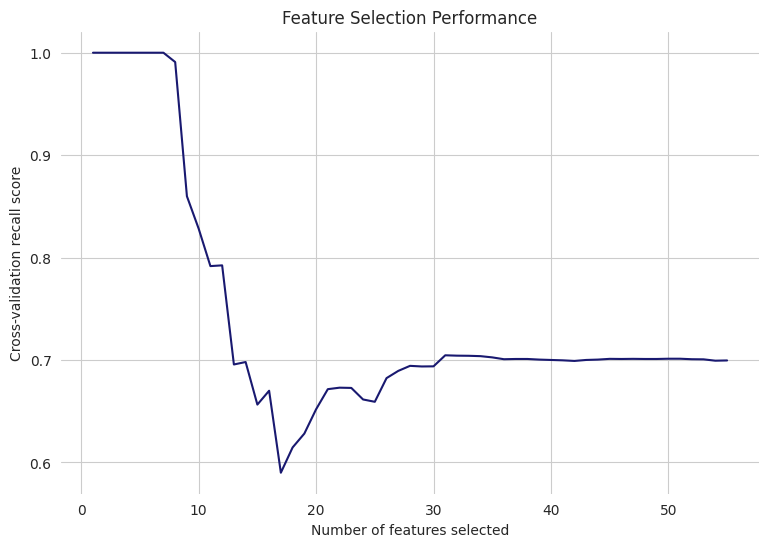

In [26]:
# Access the mean test scores from the cv_results
mean_scores = rfecv.cv_results_['mean_test_score']

# Plotting the number of features versus cross-validation scores
sns.set_style("whitegrid")

plt.figure(figsize=(9, 6))
plt.plot(range(1, len(mean_scores) + 1), mean_scores, color = "midnightblue")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation recall score")
plt.title("Feature Selection Performance")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

The graph reveals a promising start with high recall for a small number of features, yet as more features are included, the recall begins to decline, suggesting diminishing returns. This plateau indicates that beyond a certain point, additional features do not substantially improve performance.

### Implement Model with Selected Features

Guided by the insights from our feature selection process, we proceed to implement the model using the **top 12 features** identified. This refined approach not only targets crucial feature interactions but does so without overcomplicating the model, striking an optimal balance between robustness and generalizability:

In [27]:
# Feature selection using RFE
model = LogisticRegression(max_iter=1000)

# Selecting top 12 features
rfe = RFE(model, n_features_to_select=12)
fit = rfe.fit(X_train_undersampled, y_train_undersampled)
selected_features = X_train_undersampled.columns[fit.support_]
X_train_rfe = X_train_undersampled[selected_features]
X_test_rfe = X_test[selected_features]

# Train logistic regression model on selected features
trial_model = LogisticRegression(max_iter=1000)
trial_model.fit(X_train_rfe, y_train_undersampled)
y_pred = trial_model.predict(X_test_rfe)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.46      0.63    223915
        True       0.02      0.79      0.04      3603

    accuracy                           0.47    227518
   macro avg       0.51      0.63      0.34    227518
weighted avg       0.98      0.47      0.62    227518



The focused selection significantly enhances the model's recall for identifying true positives, achieving a recall rate of 0.79. This improvement in recall underscores the effectiveness of our strategy, enabling the model to efficiently and accurately detect fraud with a thoughtful and strategic approach.

## Hyperparameter Tuning with Regularization

To further refine our logistic regression model, we explore the potential of regularization techniques. Regularization can help improve model performance by preventing overfitting and enhancing the model's ability to generalize. We set up a pipeline integrating undersampling with logistic regression, configured to test various combinations of **regularization strength (C)** and the **elastic net mixing parameter (l1_ratio)**. This configuration allows us to explore a spectrum from Ridge regression (l1_ratio = 0) to Lasso regression (l1_ratio = 1) and combinations in between.

In [28]:
# Setup pipeline and GridSearchCV for hyperparameter tuning
pipeline = ImbPipeline([
    ('undersampler', RandomUnderSampler(random_state=2024)),
    ('classifier', LogisticRegression(
        penalty='elasticnet', solver='saga', max_iter=5000, random_state=2024))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=2)
grid_search.fit(X_train_rfe, y_train_undersampled)
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .........classifier__C=0.01, classifier__l1_ratio=0; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__l1_ratio=0; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__l1_ratio=0; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__l1_ratio=0; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__l1_ratio=0; total time=   0.1s
[CV] END ......classifier__C=0.01, classifier__l1_ratio=0.25; total time=   0.2s
[CV] END ......classifier__C=0.01, classifier__l1_ratio=0.25; total time=   0.3s
[CV] END ......classifier__C=0.01, classifier__l1_ratio=0.25; total time=   0.2s
[CV] END ......classifier__C=0.01, classifier__l1_ratio=0.25; total time=   0.2s
[CV] END ......classifier__C=0.01, classifier__l1_ratio=0.25; total time=   0.2s
[CV] END .......classifier__C=0.01, classifier__l1_ratio=0.5; total time=   0.2s
[CV] END .......classifier__C=0.01, classifier_

The initial results indicate the best combination achieves a recall of approximately 0.79.

### Explore More Focused Parameter Grid

We refined our parameter grid to fine-tune these settings further:

In [29]:
# Updated parameter grid
param_grid_refined = {
    'classifier__C': [0.05, 0.1, 0.15, 0.2, 0.25],
    'classifier__l1_ratio': [0.75, 0.85, 0.95, 1]
}

# Configure the GridSearchCV with refined parameters
grid_search_refined = GridSearchCV(
    pipeline,
    param_grid_refined,
    cv=5,
    scoring='recall',
    verbose=2
)

# Fit GridSearchCV on the training data using selected features
grid_search_refined.fit(X_train_rfe, y_train_undersampled)

# Output the best parameters and recall score from the refined search
print("Refined Best parameters found: ", grid_search_refined.best_params_)
print("Refined Best f1 score: ", grid_search_refined.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.75; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.75; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.75; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.75; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.75; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.85; total time=   0.2s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.85; total time=   0.2s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.85; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.85; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.85; total time=   0.1s
[CV] END ......classifier__C=0.05, classifier__l1_ratio=0.95; total time=   0.2s
[CV] END ......classifier__C=0.05, classifier__

Although the refined search confirms the optimal settings around a recall of 0.79, this detailed optimization process importantly ensures our model is robust and well-calibrated.

In [30]:
# Evaluate the best model on the test set
best_model = grid_search_refined.best_estimator_
y_pred_final = best_model.predict(X_test_rfe)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_final))

Classification Report on Test Data:
              precision    recall  f1-score   support

       False       0.99      0.46      0.63    223915
        True       0.02      0.79      0.04      3603

    accuracy                           0.47    227518
   macro avg       0.51      0.62      0.34    227518
weighted avg       0.98      0.47      0.62    227518



While the improvements in recall were modest, incorporating regularization has significantly bolstered our model's robustness, preventing overfitting and enhancing its ability to generalize to unseen data. Armed with this refined model, we now turn our attention to optimizing decision thresholds to further enhance our model's fraud detection capabilities.

## Threshold Optimization

As we refine our fraud detection model, understanding how different decision thresholds affect our key metrics—precision, recall, and the F1 score—is essential. These metrics help us evaluate the trade-offs and potential impacts of various threshold settings on our model's performance.

To explore these dynamics, we chart the progression of precision, recall, and F1 scores as we adjust the decision threshold. This analysis is crucial for balancing the sensitivity of our model (its ability to identify fraud accurately) with its specificity (its ability to ignore non-fraudulent transactions).

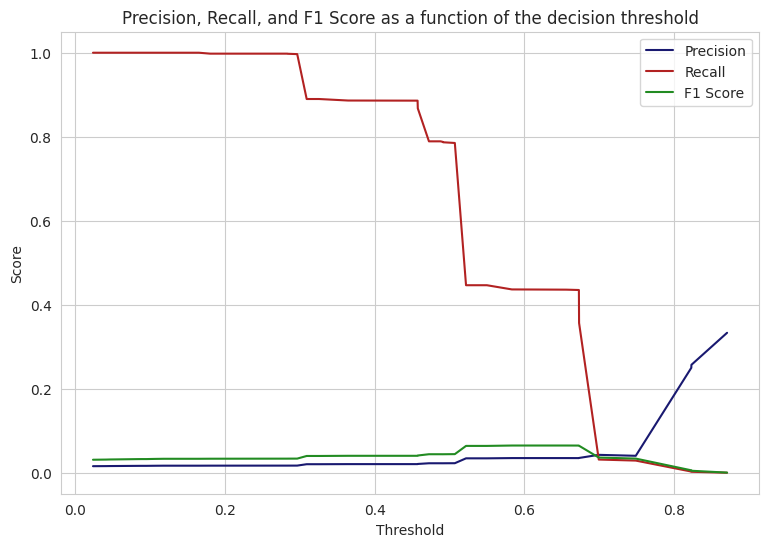

In [31]:
def evaluate_thresholds(probabilities, y_true):
    precision, recall, thresholds = precision_recall_curve(y_true, probabilities)
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Plot precision-recall curve
    plt.figure(figsize=(9, 6))
    plt.plot(thresholds, precision[:-1], 'midnightblue', label='Precision')
    plt.plot(thresholds, recall[:-1], 'firebrick', label='Recall')
    plt.plot(thresholds, f1_scores[:-1], 'forestgreen', label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score as a function of the decision threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return precision, recall, thresholds, f1_scores

# Get probability scores from your model
probability_scores = best_model.predict_proba(X_test_rfe)[:, 1]

# Evaluate the model at various thresholds
precision, recall, thresholds, f1_scores = evaluate_thresholds(probability_scores, y_test)

After thoughtful analysis of different decision thresholds, we've decided to **shift our threshold from 0.5 to 0.4**. This adjustment significantly elevates the recall to 0.89, dramatically improving our model’s ability to identify fraudulent transactions. While this change does indeed reduce precision—introducing a higher frequency of false positives—the benefit of capturing a greater proportion of actual fraud cases outweighs the cost. Opting for a 0.4 threshold strategically emphasizes our commitment to minimizing fraud incidence, ensuring that our detection system is attuned to prioritize security even at the expense of some over-detection.

In [32]:
# Get the probability scores for the positive class
probas = best_model.predict_proba(X_test_rfe)[:, 1]

# Define the new threshold
new_threshold = 0.4

# Generate predictions based on the new threshold
y_pred_adjusted = (probas >= new_threshold).astype(int)

# Generate evaluation metrics
print("Classification Report for Adjusted Threshold = 0.4:")
print(classification_report(y_test, y_pred_adjusted))

Classification Report for Adjusted Threshold = 0.4:
              precision    recall  f1-score   support

       False       0.99      0.33      0.49    223915
        True       0.02      0.89      0.04      3603

    accuracy                           0.34    227518
   macro avg       0.51      0.61      0.27    227518
weighted avg       0.98      0.34      0.49    227518



## Interpret Final Model

After putting in considerable effort to refine our model, we now turn our attention to the coefficients to unpack how different features influence the likelihood of fraud. This analysis is vital, helping us illuminate the nuanced relationships that define our predictions and guide our understanding of fraud's underlying patterns.

In [33]:
# Extract the classifier step from the pipeline
classifier = best_model.named_steps['classifier']

# Get coefficients
coefficients = classifier.coef_[0]

# Ensure feature_names are those used in the model
feature_names = X_train_rfe.columns

# Create a DataFrame to view the features and their corresponding coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Display the DataFrame sorted by the absolute values of coefficients to see the most influential features
coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values('abs_coefficient', ascending=False, inplace=True)
coef_df.drop('abs_coefficient', axis=1, inplace=True)

print(coef_df)

                                      Feature  Coefficient
6                   merchantCategoryCode_fuel    -2.852789
8             merchantCategoryCode_mobileapps    -2.280612
10  merchantCategoryCode_online_subscriptions    -2.156744
5          merchantCategoryCode_food_delivery    -1.542162
3                merchantCategoryCode_airline     1.064175
1                             posEntryMode_05    -0.892227
0                 merchantCountryCode_Unknown     0.816081
2        transactionType_ADDRESS_VERIFICATION    -0.756163
9          merchantCategoryCode_online_retail     0.693878
11             merchantCategoryCode_rideshare     0.692757
4            merchantCategoryCode_cable/phone     0.000000
7                    merchantCategoryCode_gym     0.000000


This table is sorted by the absolute value of the coefficients, which helps us identify the most influential features at a glance.

Next, we bring these insights into a visual context:

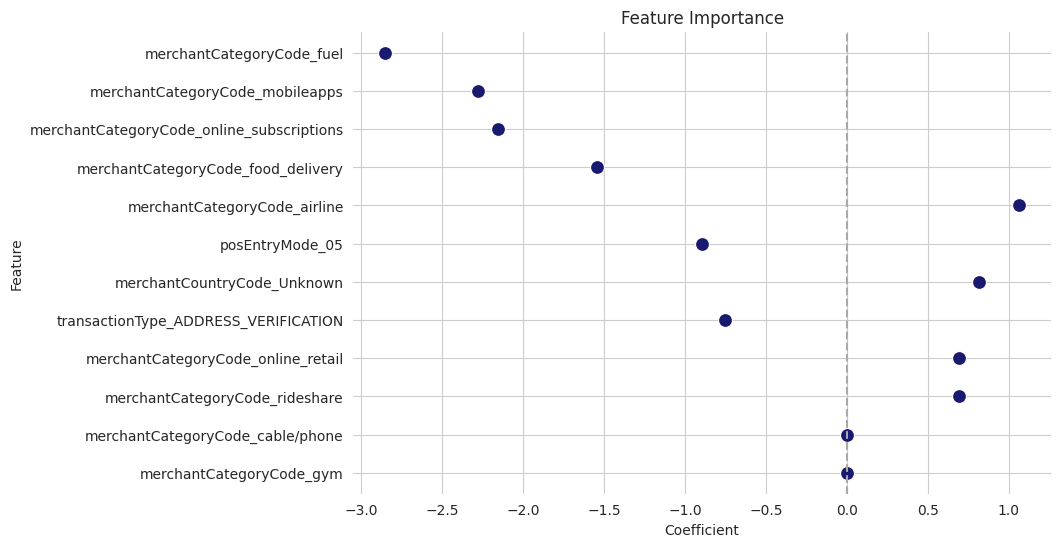

In [34]:
# Visualize feature importance
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")

# Create the scatterplot
sns.scatterplot(data=coef_df, y='Feature', x='Coefficient', color='midnightblue', s=100)

# Add a vertical line at x=0
plt.axvline(x=0, color='darkgrey', linestyle='--')

# Setting labels and title
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Remove the outer spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

In this scatter plot, features positioned to the left of the zero line — such as **fuel**, **mobile apps**, **online subscriptions**, **food delivery**, **POS Entry Mode 05** (where a chip-enabled card is physically inserted into a chip reader), and **address verification** (a process where a merchant verifies the cardholder's address with the card issuer to prevent fraud) — exhibit negative coefficients. This indicates they are associated with a decreased likelihood of fraud, serving as strong protective factors. Conversely, features on the right, notably in the **airline**, **online retail**, and **rideshare** categories, along with transactions from **unknown merchant countries**, show positive coefficients, highlighting a higher risk of fraud in these areas.

## Assessing Economic Impact

As our exploration reaches its conclusion, we reintegrate the predicted labels back into the test dataset to assess the tangible economic impact of accurately identified fraudulent transactions.

In [35]:
# Make a copy to avoid modifying the original DataFrame directly
X_test_adjusted = X_test_rfe.copy()

# Add the predicted labels back to the test data safely
X_test_adjusted['predicted_fraud'] = y_pred_adjusted
X_test_adjusted['true_fraud'] = y_test
X_test_adjusted['transactionAmount'] = df_cleaned.loc[X_test_rfe.index, 'transactionAmount']

# Filter for the successfully identified fraudulent transactions
identified_frauds = X_test_adjusted[(X_test_adjusted['predicted_fraud'] == 1) & (X_test_adjusted['true_fraud'] == 1)].copy()

# Convert normalized transaction amounts back to original scale
mean_transaction_amount = 136.8636388221906
std_transaction_amount = 147.71894888437023
identified_frauds['original_transactionAmount'] = identified_frauds['transactionAmount'] * std_transaction_amount + mean_transaction_amount

# Safely modify the DataFrame by specifying the index
identified_frauds.loc[:, 'original_transactionAmount'] = identified_frauds['transactionAmount'] * std_transaction_amount + mean_transaction_amount

# Sum the original transaction amounts for identified fraudulent transactions
total_fraud_amount_identified_original = identified_frauds['original_transactionAmount'].sum()

print(f"Total amount of fraudulently identified transactions on original scale: ${total_fraud_amount_identified_original:.2f}")

Total amount of fraudulently identified transactions on original scale: $748347.75


This method has revealed approximately **$748,348** in fraudulent transactions, underlining the significant economic benefits derived from our predictive model. This detection equates to a protective measure safeguarding nearly three-quarters of a million dollars, thereby illustrating the profound impact and value of our fraud detection efforts.

## Part III: Insights and Strategic Recommendations

As we wrap up our comprehensive examination of credit card fraud detection, we've derived critical insights that are instrumental in formulating strategies to enhance digital financial security:

## Insights from Model Analysis

- **Contextual Significance in Fraud Detection**: Our investigation highlights the crucial role of transactional context in identifying fraud risks. Categories such as airlines, online retail, and rideshare, along with transactions originating from unknown merchant countries, are notably prone to fraud.

- **Safeguards Against Fraud**: Contrarily, categories like fuel, mobile apps, online subscriptions, and food delivery, particularly when coupled with secure transaction methods such as POS Entry Mode 05 and address verification, markedly reduce the likelihood of fraud. These elements serve as strong protective barriers.

- **Addressing Class Imbalance**: The stark imbalance between fraudulent and legitimate transactions initially skewed our models. Utilizing under-sampling techniques refined our approach, enhancing model performance—evident from a recall improvement from 0.07 to 0.70.

- **Refinement through Feature Selection**: Narrowing our focus to 12 critical features boosted our recall score to 0.79, underscoring the importance of precise feature selection in model efficacy.

- **Stabilization via Regularization**: Incorporating Elastic Net regression with an l1 ratio of 0.95 and C of 0.1 brought substantial stability to our model. While it did not significantly enhance recall, it ensured the model's robustness and reliability in fraud prediction.

- **Optimizing Detection through Threshold Adjustments**: By modifying the decision threshold to 0.4, we achieved a recall of 0.89, markedly increasing the model's sensitivity in detecting fraudulent activities effectively.

## Strategic Recommendations

- **Targeted Monitoring for High-risk Transactions**: Instituting specialized monitoring for identified high-risk categories can substantially heighten fraud detection accuracy. This should include a focus on real-time data analysis and anomaly detection.

- **Adaptive Fraud Detection Mechanisms**: We advocate for the development of adaptable fraud detection systems that dynamically adjust based on the risk profile of each transaction. This would involve enhancing algorithms to integrate real-time assessments and historical data.

- **Enhancement of Transaction Security**: Promoting secure transaction methodologies, such as chip-enabled POS entries and rigorous address verification processes, is crucial. Increasing awareness among stakeholders about the security benefits of these measures can further mitigate fraud risks.

- **Dynamic Adjustment of Detection Thresholds**: Leveraging ongoing data analyses to dynamically fine-tune fraud detection thresholds will help balance minimizing false positives while effectively capturing fraudulent transactions.

- **Collaborative Efforts for Robust Security**: Fostering collaboration across card issuers, merchants, and security technology providers is essential for developing comprehensive, multi-faceted security strategies. Sharing insights and best practices will strengthen defense mechanisms against fraud.

By implementing these strategies, we aim to not only enhance the current fraud detection capabilities but also prepare them to adeptly counter the evolving tactics of fraudsters, ensuring the sustained security and integrity of digital financial transactions. This proactive and informed approach protects business assets and maintains customer trust.